 ### **Question D | Bouchaud Transitory Impact Model**

> With the dataset and the framework provided for TD4, estimate all the parameters of Bouchaud's price
impact model. Comment the obtained values. Is this model well specified?

In [211]:
# Open TD4 data
import pandas as pd
df = pd.read_excel("Dataset TD4.xlsx")
df

,transaction date (1=1day=24 hours),bid-ask spread,volume of the transaction (if known),Sign of the transaction,Price (before transaction)
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,NaN,1,99.984
2,0.001496,0.1015,NaN,-1,100.029
3,0.003336,0.0920,NaN,1,99.979
4,0.003952,0.1106,NaN,1,100.060
...,...,...,...,...,...
996,0.981441,0.0834,79.0,1,101.070
997,0.981875,0.1010,NaN,-1,101.120
998,0.986784,0.1007,NaN,-1,100.998
999,0.991232,0.1153,3.0,-1,100.958


In [212]:
# Rename the columns for simplicity
df.rename(columns={'transaction date (1=1day=24 hours)': 'date', 'bid-ask spread': 'spread', 'volume of the transaction (if known)': 'volume', 'Sign of the transaction': 'sign', 'Price (before transaction)': 'price'}, inplace=True)
df.head()

,date,spread,volume,sign,price
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,NaN,1,99.984
2,0.001496,0.1015,NaN,-1,100.029
3,0.003336,0.0920,NaN,1,99.979
4,0.003952,0.1106,NaN,1,100.060


Bouchaud's transitory impact model is specified as:
$$p_t = p_{-\infty} + \sum^{t-1}_{s=-\infty}G(t-s)\epsilon_s S_s V^r_s$$

Where:
- $S$ is the bid-ask spread;
- $\epsilon$ is -1 or 1 depending on whether the transaction is a buy (price = ask) or a sell (price = bid) on the market;
- $V$ is the volume of the transaction, with $r$ close to zero to have a concave function of the volume;
- $G$ is a function worth 0 on $\mathbb{R}^-$, which can be interpreted as the impact of a single order.

There are many NaNs in the volume column, and we don't have a reason to believe they are all quote updates, so we will fill the missing values with the median of the volume column.


In [213]:
# We replace missing values by the median to avoid losing most the data
df['volume'] = df['volume'].fillna(df['volume'].median())
df.head()

,date,spread,volume,sign,price
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,77.0,1,99.984
2,0.001496,0.1015,77.0,-1,100.029
3,0.003336,0.0920,77.0,1,99.979
4,0.003952,0.1106,77.0,1,100.060


Let's plot the price evolution, this will allow us to get a clearer view on the data

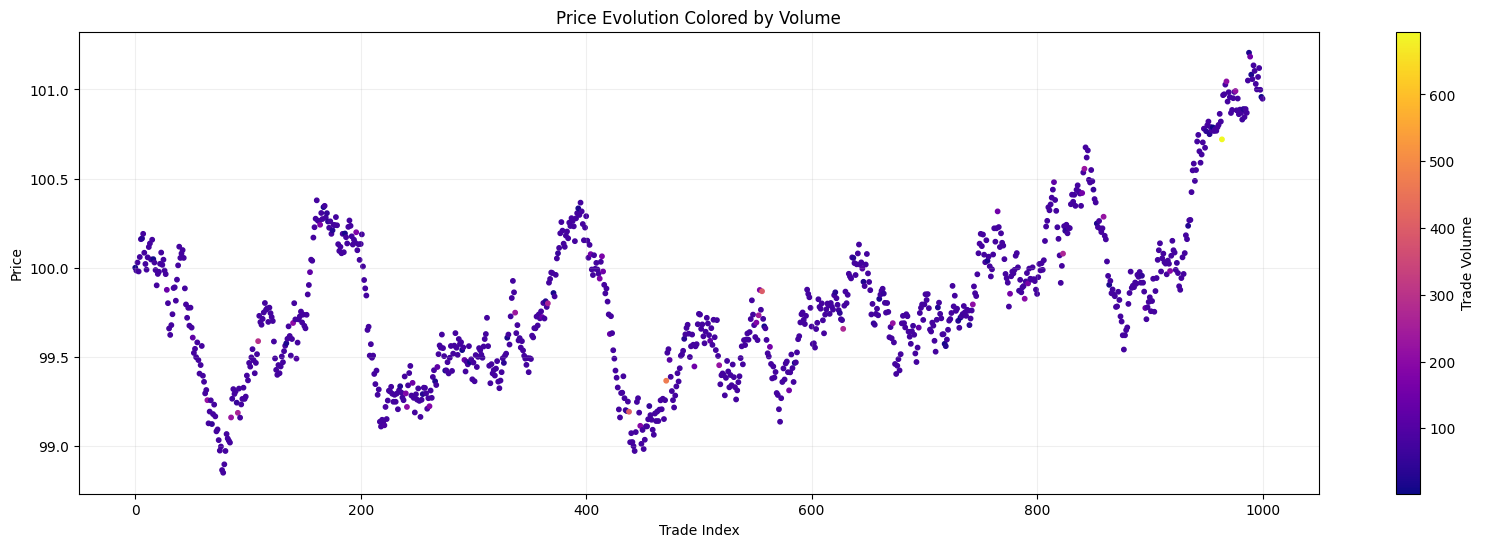

In [ ]:
import matplotlib.pyplot as plt
# Setup the plot
fig, ax = plt.subplots(figsize=(20, 6))
# We plot the price evolution with color intensity for the volume
sc = ax.scatter(df.index, df['price'], c=df['volume'], cmap='plasma', s=10)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Trade Volume')
ax.set_xlabel('Trade Index')
ax.set_ylabel('Price')
ax.grid(True, alpha=0.2)
plt.show()


To estimate the parameters of the Bouchaud model, we want to have a series of price returns instead of pure value.

Indeed, we can transform the equation:

$$p_{t+1} - p_t = \sum_{l=0}^{L} \left[ G(l+1) - G(l) \right] \cdot (\epsilon_{t-l} S_{t-l} V_{t-l}^r)$$

For which we want to estimate $\Delta G$ and $r$.


In [215]:
# We reformat the dataset to have a clearer view of what happens by aligning the impacted price to the trade that impacts it
df['next_price'] = df['price'].shift(-1)
# We compute the returns
df['price_change'] = df['next_price'] - df['price']
df = df.dropna(subset=['price_change'])
df.head()

,date,spread,volume,sign,price,next_price,price_change
0,0.000202,0.1100,8.0,-1,100.000,99.984,-0.016
1,0.001070,0.1030,77.0,1,99.984,100.029,0.045
2,0.001496,0.1015,77.0,-1,100.029,99.979,-0.050
3,0.003336,0.0920,77.0,1,99.979,100.060,0.081
4,0.003952,0.1106,77.0,1,100.060,100.160,0.100


Market impact is concave with respect to volume, which means for example that a trade 10x larger moves the price less than 10x as much. This is why we have the exponent $r < 1$. But because $r$ is an exponent, we cannot find it using a linear regression directly as it makes the equation non-linear.

To solve that problem, we will do a grid search with different values of $r$ to estimate it's true value.

In [216]:
import numpy as np
from sklearn.linear_model import LinearRegression
# We define a number of lags of 20, we look 20 steps back in the data
L = 20
# test 30 r values from 0.1 to 1.0
r_grid = np.linspace(0.1, 1.0, 30)

scores = []
models = {}
# We define the impact term of the model= epsilon * spread * volume^r
def impact_term(df, r):
    return df['sign'] * df['spread'] * (df['volume'] ** r)


The regression problem can be written this way: 

$$\text{R}_t = \beta_0 \cdot I_t + \beta_1 \times I_{t-1} + \beta_2 \times I_{t-2} + \dots + \beta_{19} \times I_{t-19}$$

In [217]:
# Grid search
for r in r_grid:
    # First calculate impact term for the current r
    current_df = df.copy()
    current_df['impact'] = impact_term(current_df, r)
    # we then add the lagged values
    # We want to predict price change at t using the past impacts
    features = []
    # We create lagged columns for each step that we look back to
    for i in range(L):
        # Label columns lag_i
        col_name = f'lag_{i}'
        # slide the impact column in the dataframe by i steps
        current_df[col_name] = current_df['impact'].shift(i)
        # We then add to features
        features.append(col_name)
    #remove missing values created by shifting data
    reg_df = current_df.dropna(subset=features)
    # We structure the regression model specified above
    X = reg_df[features]
    y = reg_df['price_change']
    # run the linear regression
    reg = LinearRegression() 
    reg.fit(X, y)
    # get the result
    score = reg.score(X, y) 
    scores.append(score)
    models[r] = reg

Chosen r: 0.5655
R²: 0.7691


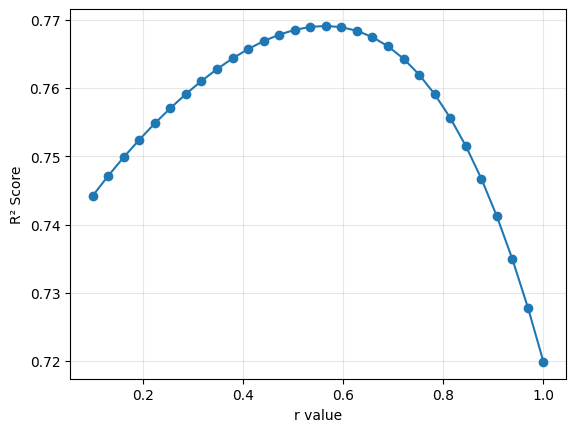

In [ ]:
# Finally, we keep the highest value found of r
best_idx = np.argmax(scores)
best_r = r_grid[best_idx]
best_r2 = scores[best_idx]
best_model = models[best_r]
# show results
print(f"Chosen r: {best_r:.4f}")
print(f"R²: {best_r2:.4f}")
# We make a plot for the report
plt.figure()
plt.plot(r_grid, scores, marker='o')
plt.xlabel("r value")
plt.ylabel("R² Score")
plt.grid(True, alpha=0.2)
plt.show()